In [8]:
%cd /Users/digvijaykasana/Desktop/dissertation

/Users/digvijaykasana/Desktop/dissertation


/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading and splitting dataset...
Initializing dataset...
Dataset initialized with 1113 samples.
Dataset split into 780 training samples, 222 validation samples, and 111 test samples.
Starting training and validation...
Epoch 1/10
Training loss: 2.2551
Validating batch 1/56...
Validating batch 2/56...
Validating batch 3/56...
Validating batch 4/56...
Validating batch 5/56...
Validating batch 6/56...
Validating batch 7/56...
Validating batch 8/56...
Validating batch 9/56...
Validating batch 10/56...
Validating batch 11/56...
Validating batch 12/56...
Validating batch 13/56...
Validating batch 14/56...
Validating batch 15/56...
Validating batch 16/56...
Validating batch 17/56...
Validating batch 18/56...
Validating batch 19/56...
Validating batch 20/56...
Validating batch 21/56...
Validating batch 22/56...
Validating batch 23/56...
Validating batch 24/56...
Validating batch 25/56...
Validating batch 26/56...
Validating batch 27/56...
Validating batch 28/56...
Validating batch 29/56...
Val

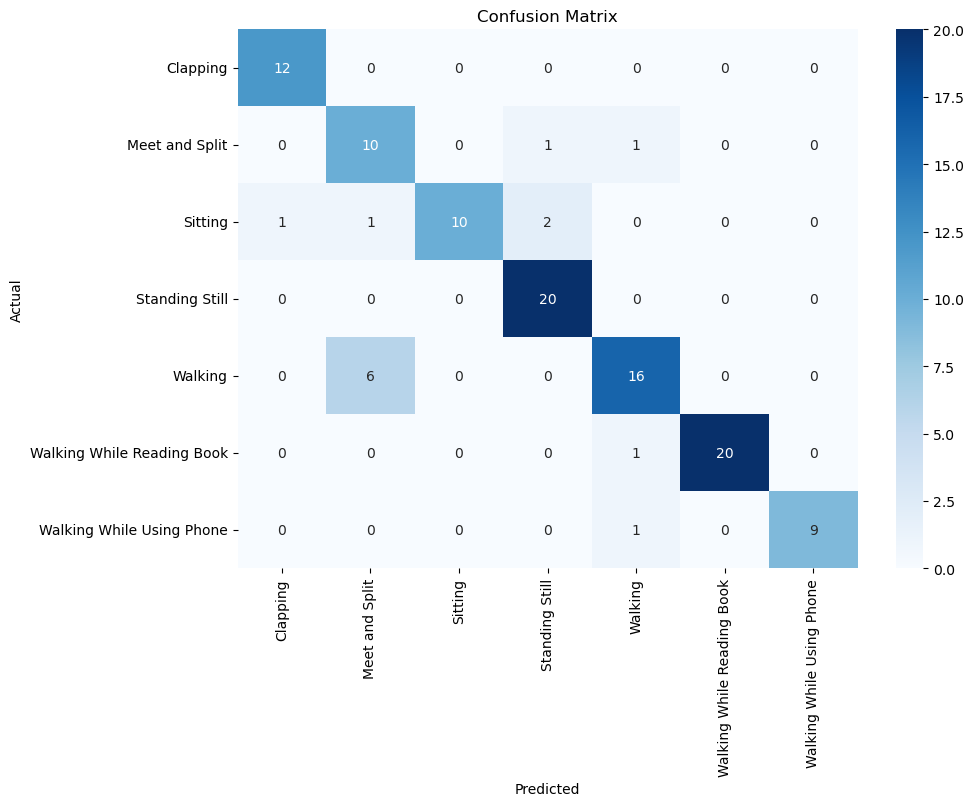

Plotting training curves...


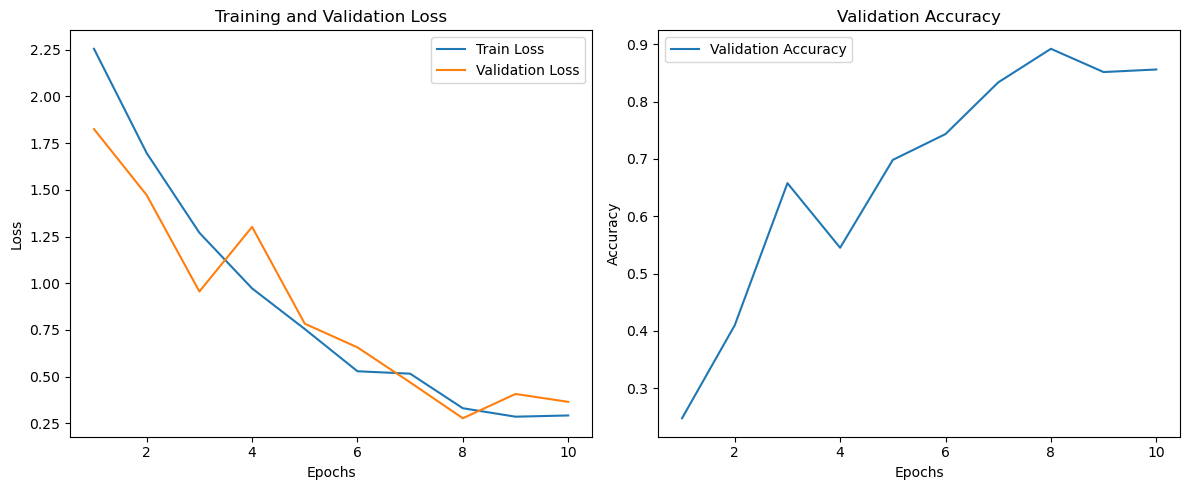

In [3]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

class VideoDataset(Dataset):
    def __init__(self, root_dir, processor):
        ...
    
    def extract_features(self, frames):
        features = []
        for frame in frames:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Ensure frame is in RGB
            frame = Image.fromarray(frame)
            inputs = self.processor(images=frame, return_tensors="pt")
            features.append(inputs["pixel_values"].squeeze(0))
        features = torch.stack(features).mean(0)  # Average the features along the batch dimension
        return features.numpy()

    def __getitem__(self, idx):
        ...
        return features, torch.tensor(label_idx)

def train_and_validate(model, train_loader, val_loader, device, num_classes, num_epochs=10):
    model.train()
    model.to(device)
    
    # Add a linear layer for classification to the model
    classification_layer = nn.Linear(model.visual.output_dim, num_classes).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(model.parameters()) + list(classification_layer.parameters()), lr=1e-4)

    for epoch in range(num_epochs):
        ...
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            image_features = model.encode_image(inputs).to(device)  # Get image features
            outputs = classification_layer(image_features)  # Pass features through the classification layer
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            ...

    print("Model training complete and saved.")




def evaluate_and_plot(model, test_loader, device, classes):
    print("Evaluating model on test set...")
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            print(f"Evaluating batch {batch_idx + 1}/{len(test_loader)}...")
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model.get_image_features(pixel_values=inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.show()

    return test_accuracy

def plot_training_curves(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    print("Plotting training curves...")
    plt.figure(figsize=(12, 5))

    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    # Plot accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Validation Accuracy")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    dataset_dir = "HumanActivityRecognition-VideoDataset"  # Path to your dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Load and split dataset
    train_loader, val_loader, test_loader, num_classes = load_and_split_dataset(dataset_dir, processor)

    # Train and validate the model
    train_losses, val_losses, val_accuracies = train_and_validate(model, train_loader, val_loader, device, num_classes)

    # Evaluate and plot results
    test_accuracy = evaluate_and_plot(model, test_loader, device, train_loader.dataset.dataset.classes)
    plot_training_curves(train_losses, val_losses, val_accuracies)

In [13]:
%%writefile app3.py
import streamlit as st
import torch
import cv2
import numpy as np
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
import os

# Load the model and processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.load_state_dict(torch.load("fine_tuned_clip.pth", map_location=device))
model.to(device)
model.eval()

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Classes 
classes = [
    'clapping',
    'meeting_and_splitting',
    'sitting',
    'standing_still',
    'walking',
    'walking_while_reading_a_book',
    'walking_while_using_phone'
]

def preprocess_frame(frame):
    frame = cv2.resize(frame, (224, 224))
    frame = np.array(frame) / 255.0
    return (frame * 255).astype(np.uint8)

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

def extract_features(frames):
    features = []
    for frame in frames:
        frame = preprocess_frame(frame)
        frame = Image.fromarray(frame)
        inputs = processor(images=frame, return_tensors="pt")
        features.append(inputs["pixel_values"].squeeze(0).numpy())
    return np.mean(features, axis=0)  # Average the features

def predict(video_path):
    frames = extract_frames(video_path)
    features = extract_features(frames)
    inputs = torch.tensor(features).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model.get_image_features(pixel_values=inputs)
        preds = torch.argmax(outputs, dim=1)
        return classes[preds.item()]

# Streamlit App
st.title("Human Activity Recognition")

# Video upload
uploaded_video = st.file_uploader("Upload a video", type=["mp4", "avi", "mov"])

if uploaded_video is not None:
    # Save the uploaded video to a temporary file
    temp_video_path = "temp_video.mp4"
    with open(temp_video_path, "wb") as f:
        f.write(uploaded_video.read())

    st.video(temp_video_path)

    # Predict the activity in the video
    if st.button("Predict"):
        st.write("Predicting...")
        prediction = predict(temp_video_path)
        st.success(f"Predicted Activity: {prediction}")

    # Clean up the temporary video file after prediction
    if os.path.exists(temp_video_path):
        os.remove(temp_video_path)

Writing app2.py
